# Parameter Setting

In [1]:
parameters = dict(
    target = 'FP',
    subfrag_size = 4,
    out_size = 1,
    edge_size = 1,
    
    hidden_size = 72,
    dropout = 0.208,
    num_layers = 3,
    num_timesteps = 2,
)
DATAPATH = "/SSD2/bgkang/GeometryInput"
MODELPATH = "../Model/FP-2024-05-30-07-22-51"

# Cinnamaldehyde
# SMILES = "O=CC=Cc1ccccc1"; TRUE_VAL = 71 + 273.15
# 1,1'-(1,3-Phenylene)bis(1H-pyrrole-2,5-dione)
# SMILES = "CC1=CC(=O)N(C1=O)CC2=CC(=CC=C2)CN3C(=O)C=C(C3=O)C"; TRUE_VAL = 250.7 + 273.15
# Adrenosterone
SMILES = "CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C"; TRUE_VAL = 206.0 + 273.15

SYMBOL = dict([(1, "H"), (6, "C"), (8, "O"), (7, "N"), (0, "*")]) # Atomic Symbol
RADII = dict([(1, 25), (6, 70), (8, 60), (7, 65), (0, 10)]) # Atomic Radius
# COLOR = [0.56640625, 0.65625, 0.81640625, 0.0] # Serenity - #92A8D1
COLOR = [0.71, 0.56, 0.68, 0.0] #B48EAD

# Prediction

In [2]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import GNNExplainer
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile

In [3]:
dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
loader = DataLoader([smiles2data(SMILES, TRUE_VAL)] * 100)
data = [data for data in loader][0]

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH))
model.eval()

result = []

for data in loader:
    out = model(x = data.x,
                edge_index = data.edge_index,
                edge_attr = data.edge_attr,
                sub_batch = data.sub_batch,
                jt_index = data.jt_index,
                jt_attr = data.jt_attr,
                numFrag = torch.tensor([data.numFrag]).view(-1,),
                mol_x = data.mol_x,
                mol_edge_index = data.mol_edge_index,
                mol_edge_attr = data.mol_edge_attr,
                numAtom = torch.tensor([data.numAtom]).view(-1,),
               )

    result.append(out.item() * dataset.std + dataset.mean)

result = sum(result) / len(result)
    
print(f"SMILES : {SMILES} | True : {data.y.item():.6f} | Predicted : {result:.6f}")

	DataDump found for 'FP'. Loading dumped data.
Training : 754 | Validation : 94 | Test : 95
Total : 943
SMILES : CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C | True : 479.149994 | Predicted : 505.632065


# Explainer

In [4]:
explainer = Explainer(
        model = model,
        algorithm = GNNExplainer(epochs = 500),
        explanation_type = 'model',
        model_config = dict(
            mode = 'regression',
            task_level = 'graph',
            return_type = 'raw',
            ),
        node_mask_type = 'object',
        )

explanation = explainer(
        x = data.x,
        edge_index = data.edge_index,
        edge_attr = data.edge_attr,
        sub_batch = data.sub_batch,
        jt_index = data.jt_index,
        jt_attr = data.jt_attr,
        numFrag = torch.tensor([data.numFrag]).view(-1, ),
        mol_x = data.mol_x,
        mol_edge_index = data.mol_edge_index,
        mol_edge_attr = data.mol_edge_attr,
        numAtom = torch.tensor([data.numAtom]).view(-1,),
)

In [5]:
score = [explanation.node_mask[i][0].item() for i in range(explanation.node_mask.shape[0])]
score

[0.042516544461250305,
 0.03973516821861267,
 0.040753334760665894,
 0.039790816605091095,
 0.03958344832062721,
 0.952369749546051,
 0.7580828070640564,
 0.5955845713615417,
 0.9007000923156738,
 0.9339642524719238,
 0.932135283946991,
 0.9180941581726074,
 0.9253555536270142,
 0.929338812828064,
 0.9395604729652405,
 0.946790874004364,
 0.9373137950897217,
 0.9182236194610596,
 0.9337829947471619,
 0.901694655418396,
 0.9121631383895874,
 0.8908203840255737,
 0.8778362274169922,
 0.8967049717903137,
 0.9025416374206543,
 0.8535006642341614,
 0.9304972887039185,
 0.8438481092453003,
 0.1827964037656784,
 0.9032264351844788,
 0.9188782572746277,
 0.9188928008079529,
 0.9160791039466858,
 0.921962320804596,
 0.9000800848007202,
 0.0401235856115818,
 0.6228068470954895,
 0.3797011375427246,
 0.19073380529880524,
 0.6063351035118103,
 0.7438555955886841,
 0.8487815260887146,
 0.7936655879020691,
 0.05528153106570244,
 0.046174049377441406,
 0.04295342415571213,
 0.041355181485414505,
 0.0

# Molecule Visualization

In [6]:
def graph_visualize(G, ax):
    pos = nx.spring_layout(G)
    
    colors = []
    for n in G.nodes():
        COLOR[3] = G.nodes[n]['score']
        colors.append(tuple(COLOR))

    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G, pos = pos, 
        labels = dict((n, f"{G.nodes[n]['label']}{n}") for n in G.nodes()),
        node_color = colors,
        ax = ax
       )

In [7]:
G = to_networkx(data, to_undirected = True)
G.add_edges_from([(int(item[0].item()), int(item[1].item())) for item in data.edge_index.T])
node_attr = dict((idx, dict(label = SYMBOL[int(data.x[idx,0])], score = score, coord = data.x[idx,1:].numpy())) 
                                   for idx, score in enumerate(score))
nx.set_node_attributes(G, node_attr)

# Subgraph Visualization

# Better Visualization

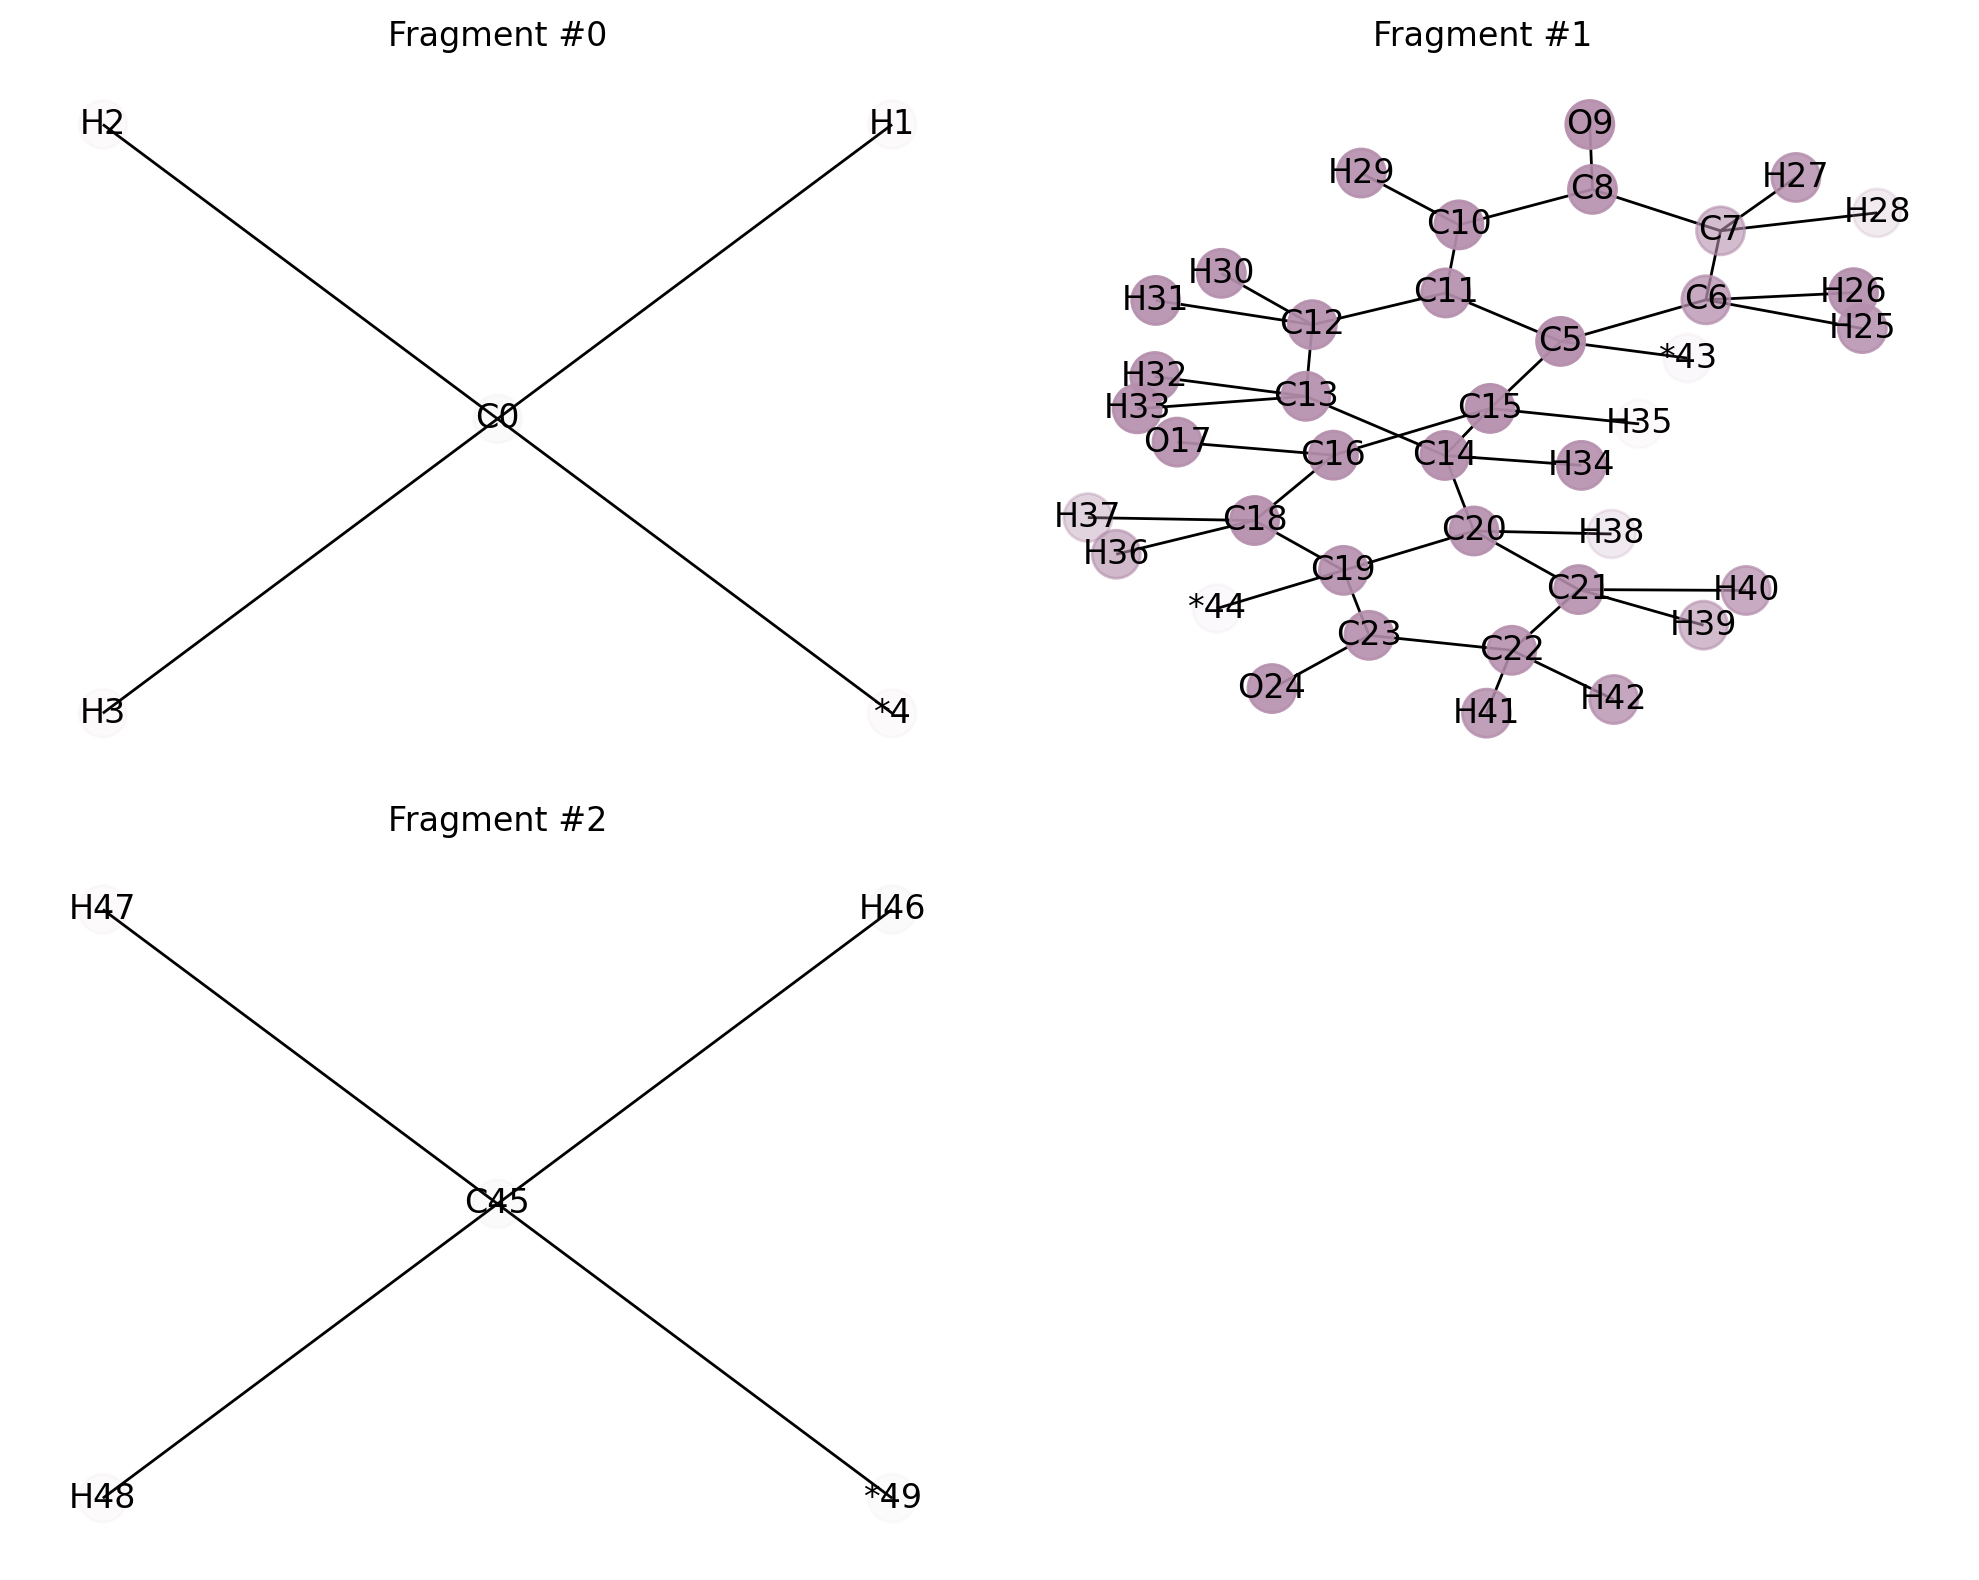

In [8]:
numFrag = data.numFrag.item()
col = 2; row = int(numFrag / col) + 1 if (numFrag % col) != 0 else int(numFrag / col)

fig, axs = plt.subplots(row, col, figsize = (10,8), dpi = 200, squeeze = True)

for i in range(row):
    for j in range(col):
        idx = i * row + j
        
        if (row == 1): temp_ax = axs[j]
        else: temp_ax = axs[i][j]
            
        if (idx < numFrag):
            index = (data.sub_batch == idx).nonzero().flatten().tolist()
            H = G.subgraph(index)
            if (row == 1): graph_visualize(H, temp_ax)
            else: graph_visualize(H, temp_ax)
            temp_ax.set_title(f"Fragment #{idx}")
        else:
            temp_ax.axis('off')

plt.tight_layout()
plt.show()

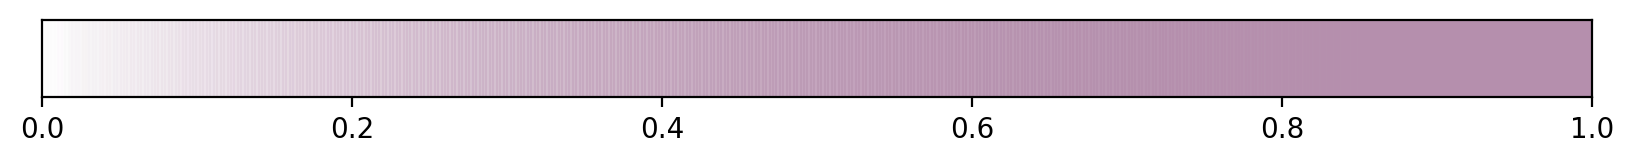

In [9]:
fig = plt.figure(figsize = (10, 0.5), dpi = 200)
ax = plt.gca()

for x in np.linspace(0,1,2000):
    plt.vlines(x, 0, 1, alpha = x, color = COLOR, lw = 0.8)
    
ax.set_yticks([])
ax.set_xlim([0,1])
ax.set_ylim([0,1])

plt.show()

# 3D Visualization

In [10]:
def visualize3D(G, ax):
    xyz = np.stack([G.nodes[i]['coord'] for i in G.nodes()])
    
    colors = []
    for n in G.nodes():
        COLOR[3] = H.nodes[n]['score']
        colors.append(tuple(COLOR))
        
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],
               c = colors,
               s = 150)

    for n in G.nodes():
        xyz_label = G.nodes[n]['coord']
        ax.text(xyz_label[0], xyz_label[1], xyz_label[2],
                s = f"{G.nodes[n]['label']}", ha = 'center', va = 'center')

    for b,e in G.edges():
        start = G.nodes[b]['coord']
        end = G.nodes[e]['coord']
        path = np.stack([start, end])
        ax.plot(path[:,0], path[:,1], path[:,2], color = 'k')

    ax.axis('off')

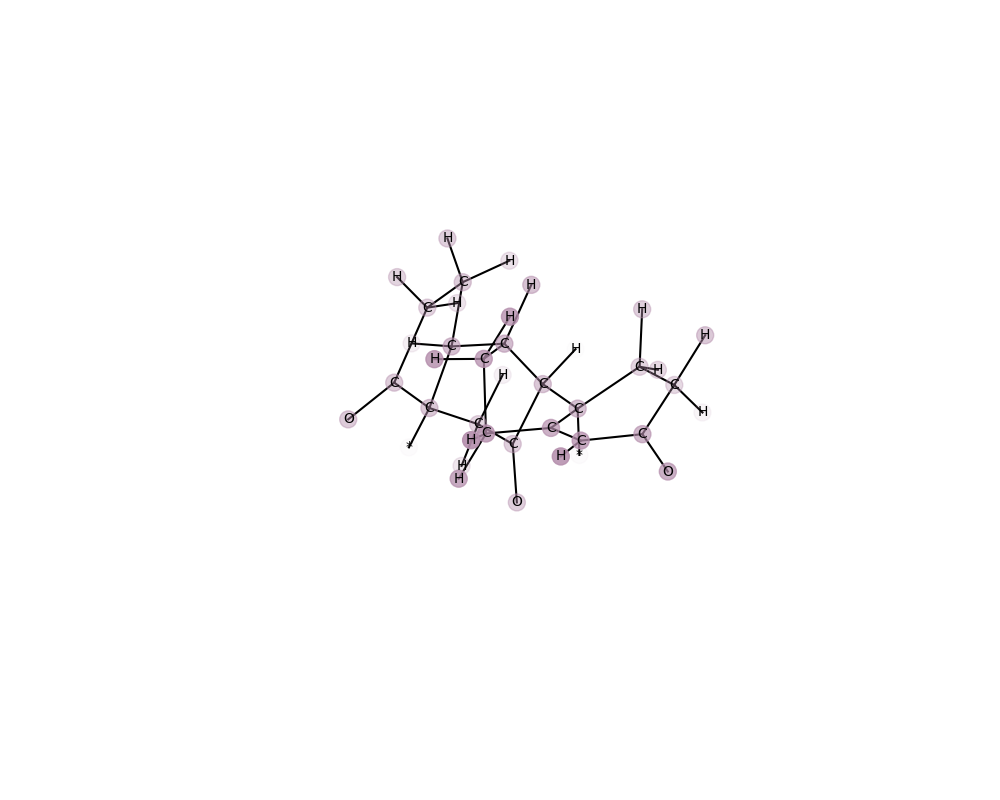

In [15]:
%matplotlib widget
index = (data.sub_batch == 1).nonzero().flatten().tolist()
H = G.subgraph(index)

fig, ax = plt.subplots(1, 1, figsize = (10,8), dpi = 100, subplot_kw = dict(projection = '3d'))

visualize3D(H, ax)

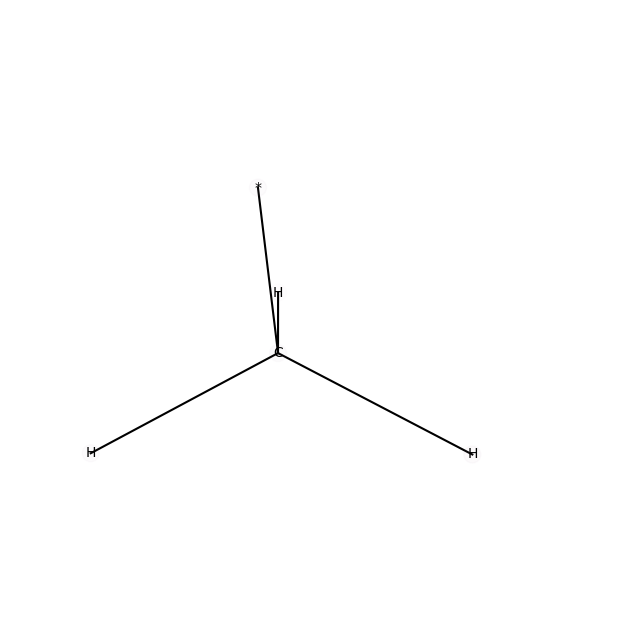

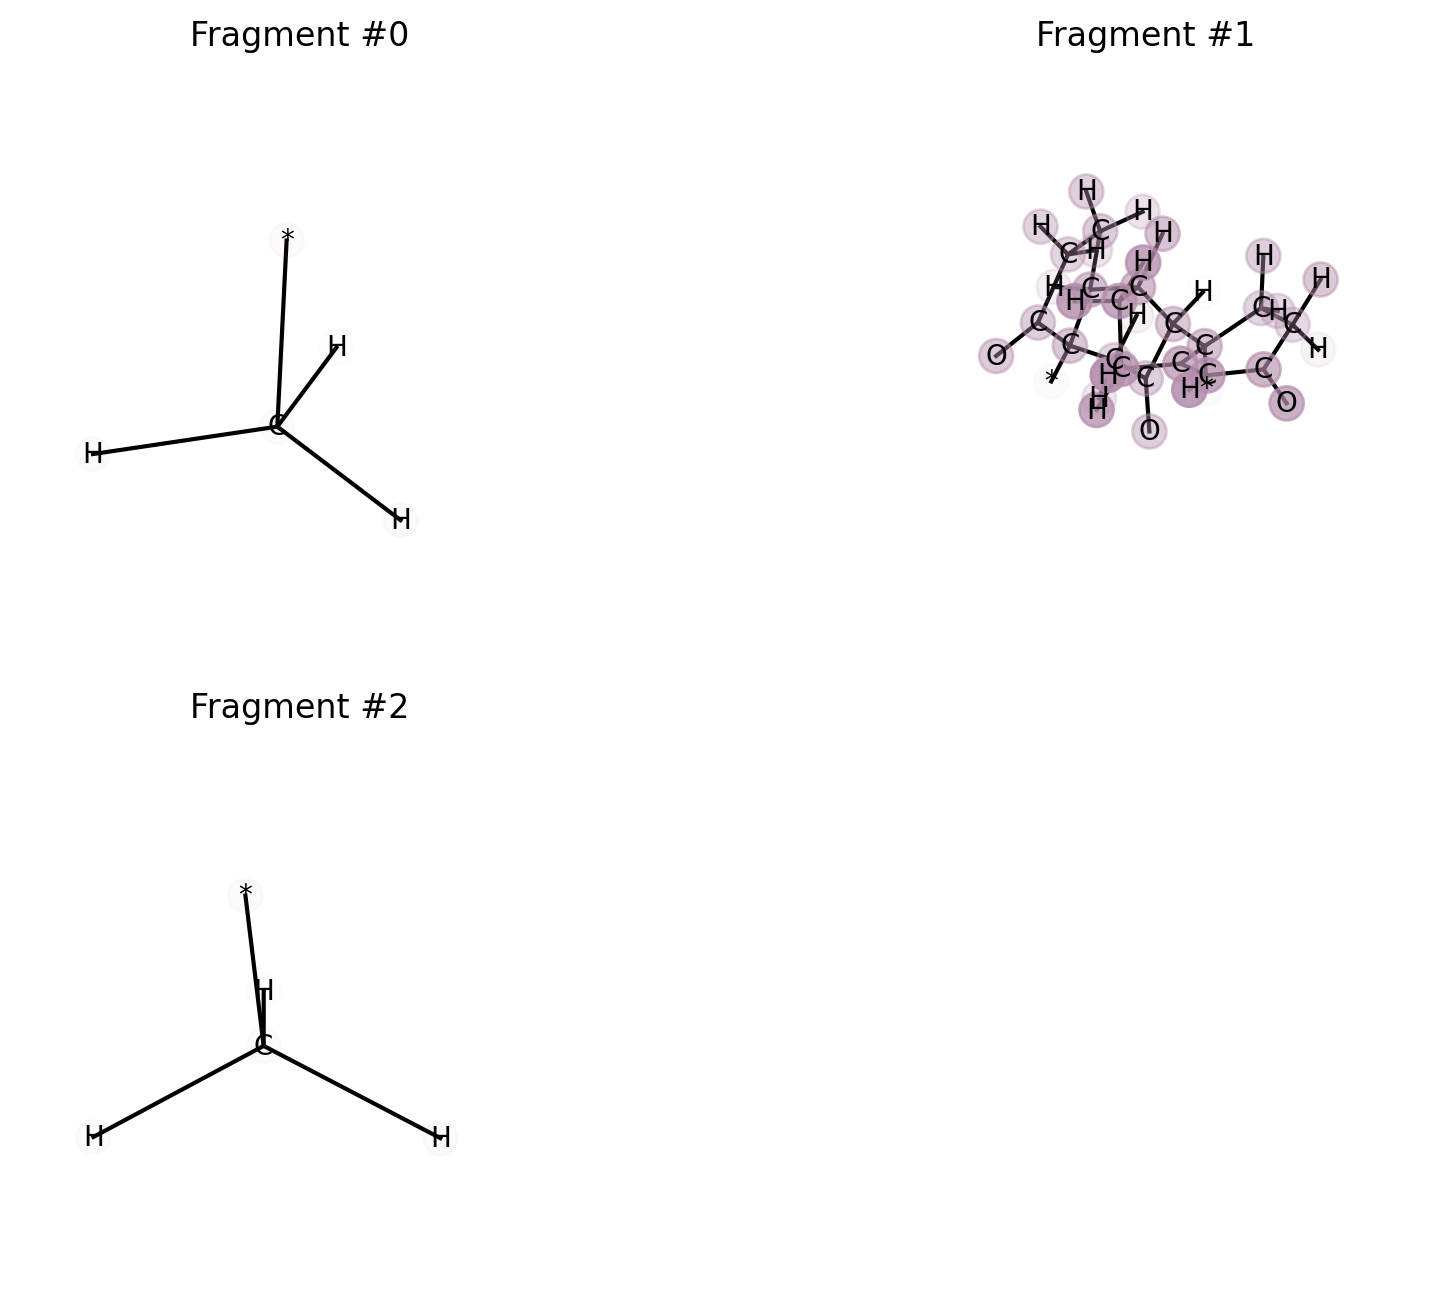

In [12]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(row, col, subplot_kw = dict(projection = '3d'), figsize = (10,8), dpi = 200, squeeze = True)

for i in range(row):
    for j in range(col):
        idx = i * row + j
        
        if (row == 1): temp_ax = axs[j]
        else: temp_ax = axs[i][j]
            
        if (idx < numFrag):
            index = (data.sub_batch == idx).nonzero().flatten().tolist()
            H = G.subgraph(index)

            xyz = np.stack([H.nodes[i]['coord'] for i in H.nodes()])
            
            colors = []
            for n in H.nodes():
                COLOR[3] = H.nodes[n]['score']
                colors.append(tuple(COLOR))
                
            temp_ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],
                            c = colors,
                            s = 150)

            for n in H.nodes():
                xyz_label = H.nodes[n]['coord']
                temp_ax.text(xyz_label[0], xyz_label[1], xyz_label[2],
                             s = f"{H.nodes[n]['label']}", ha = 'center', va = 'center')

            for b,e in H.edges():
                start = H.nodes[b]['coord']
                end = H.nodes[e]['coord']
                path = np.stack([start, end])
                temp_ax.plot(path[:,0], path[:,1], path[:,2], color = 'k')
            
            temp_ax.set_title(f"Fragment #{idx}")
            temp_ax.axis('off')
        else:
            temp_ax.axis('off')

plt.show()